In [4]:
import torch 
import matplotlib.pyplot as plt

import numpy as np

In [5]:
mix_distribution = torch.distributions.Categorical(logits=torch.ones(2))
components = torch.distributions.Independent(torch.distributions.Normal(torch.tensor([[5.,2],[-4.,1.]]), torch.tensor([[2.,5.],[3, 2.]])),1)
p = torch.distributions.MixtureSameFamily(mix_distribution,components)

In [3]:
x_axis = torch.linspace(-10,10, requires_grad=True)
xx, yy = torch.meshgrid(x_axis,x_axis)
positions = xx.reshape(-1,2)

C:\Users\Manuel Glöckler\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ..\aten\src\ATen\native\RangeFactories.cpp:23.)
  """Entry point for launching an IPython kernel.


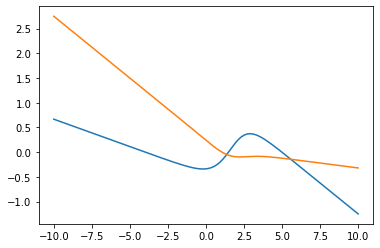

In [4]:
logp = p.log_prob(positions)
dlogp = torch.autograd.grad(logp, positions, torch.ones_like(logp))[0]

plt.plot(positions[:,0].detach(), dlogp[:,0].detach())
plt.plot(positions[:,1].detach(), dlogp[:,1].detach())

# Lest square log density gradient

We directly fit a model $f(x)$ to the true log-density gradient under the squared loss
$$ E_p[(f(x)-\nabla \log p(x))^2] = E_p[f(x)^2] - 2 E_p[f(x)\nabla \log p(x)] + const$$
The first term is easy, notice that in the second term we have 
$$  E_p[f(x)\nabla \log p(x)] = \int f(x)\nabla \log p(x) p(x)dx = \int f(x) \nabla p(x) dx$$
For the later term we can use integration by parts.
$$\int f(x) \nabla p(x) dx = [f(x)p(x)]_{-\infty}^\infty - \int \nabla f(x) p(x) dx = -E_p[\nabla f(x)]$$
As the first term vanishes under mild conditions on the tails of p(x). Thus the full loss can be written as 
$$ E_p(f(x)^2) + 2E_p([\nabla f(x)])$$

In [199]:
dataset = p.sample((10000,))
data = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=1000)

In [200]:
f = torch.nn.Sequential(torch.nn.Linear(2,50), torch.nn.Softplus(),torch.nn.Linear(50,50),torch.nn.Softplus(),torch.nn.Linear(50,50), torch.nn.Softplus(), torch.nn.Linear(50,2))

In [206]:
optimizer = torch.optim.Adam(list(f.parameters()) ,lr=1e-3)
for i in range(10):
    for samples in data:
        optimizer.zero_grad()
        #samples = samples[:,0].unsqueeze(1)
        samples = samples.clone()
        samples.requires_grad=True
        y = f(samples)
        loss = 0
        for i in range(2):
            l1 = torch.mean(y[:,i]**2)
            l2 = torch.autograd.grad(y[:,i], samples, torch.ones_like(y[:,i]), create_graph=True)[0][:,i].mean()
            loss += l1 + 2*l2 
        loss.backward()
        optimizer.step()
    print(loss)

tensor(-0.2422, grad_fn=<AddBackward0>)
tensor(-0.2897, grad_fn=<AddBackward0>)
tensor(-0.2748, grad_fn=<AddBackward0>)
tensor(-0.2682, grad_fn=<AddBackward0>)
tensor(-0.2943, grad_fn=<AddBackward0>)
tensor(-0.2996, grad_fn=<AddBackward0>)
tensor(-0.2639, grad_fn=<AddBackward0>)
tensor(-0.2709, grad_fn=<AddBackward0>)
tensor(-0.2633, grad_fn=<AddBackward0>)
tensor(-0.2434, grad_fn=<AddBackward0>)


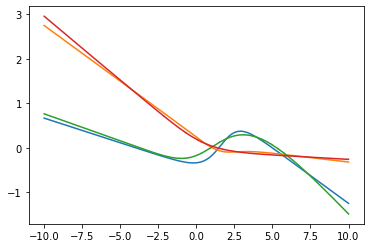

In [207]:
dlogp2 = f(positions)
plt.plot(positions[:,0].detach(), dlogp[:,0].detach())
plt.plot(positions[:,1].detach(), dlogp[:,1].detach())
plt.plot(positions[:,0].detach(), dlogp2[:,0].detach())
plt.plot(positions[:,1].detach(), dlogp2[:,1].detach())

We can get a closed from solution if we assume that 
$$ f(x) = theta^T \phi(x) $$
is a linear model. Assume we use Gaussian basis functions $\phi(x) = \exp(-||x-x_i||^2/2\sigma^2)$ Substituting this into the objective we obtain
$$ \mathcal{L}(\theta) = \theta^T G \theta + 2 \theta^T h + \lambda \theta^T\theta $$
where $[G]_{ij} = \int \phi_i(x)\phi_j(x) dx = (\pi \sigma^2)^{d/2} \exp(-||x_i-x_j||^2/4\sigma^2)$ and $h_j = \frac{1}{n} \sum_{i=1}^n \nabla \phi(x_i)$
Where we obtain 
$$ \nabla \phi(x) = \nabla \exp(-||x-x_i||^2/2\sigma^2) = \nabla (-(x-x_i)^2/2\sigma^2) *\exp(-||x-x_i||^2/2\sigma^2) = -2(x-x_i)/2\sigma^2 * \exp(-||x-x_i||^2/2\sigma^2)$$

In [373]:
sigma = 1
d= 1
samples = p.sample((10000,))
phi_x = lambda x: torch.exp(-torch.cdist(x, samples)**2/(2*sigma**2))
dphi_x = lambda x: -2*((x-samples.unsqueeze(1)).squeeze())/(2*sigma**2)*phi_x(x)
G = (np.pi*sigma**2)**(0.5*d)*torch.exp(-torch.cdist(samples,samples)**2/(4*sigma**2))

In [374]:
G = phi_x(samples)@phi_x(samples).T/10000

In [375]:
h = dphi_x(samples).mean(0)

In [379]:
G_inv = torch.inverse(G + torch.eye(G.shape[0])*0.1)

In [380]:
theta = -G_inv@h

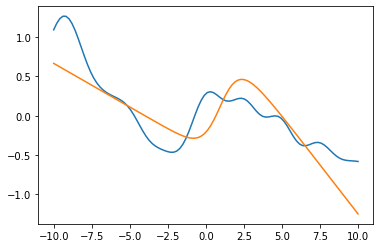

In [381]:
plt.plot(x_axis.detach(), (phi_x(x_axis.reshape(-1,1))@theta).detach().flip(0))
plt.plot(x_axis.detach(), dlogp)

# Denoising autoencoder

The optimal denoising function and the log derivative are related. Assume gaussian noise then 
$$ f^*(x) = x + \sigma \nabla \log p(x) \quad \text{for } \sigma \rightarrow 0$$
Thus we get $$\nabla \log p(x) = (f^*(x) - x)/\sigma$$

In [156]:
dae = torch.nn.Sequential(torch.nn.Linear(1,10), torch.nn.Tanh(),torch.nn.Linear(10,20), torch.nn.Sigmoid(), torch.nn.Linear(20,1))
sigma = 0.1
loss_f = torch.nn.MSELoss()

In [163]:
optimizer = torch.optim.Adam(dae.parameters(), lr=1e-2)
for i in range(100):
    optimizer.zero_grad()
    samples_noised = samples + torch.randn(samples.shape)*sigma
    loss = loss_f(samples,dae(samples_noised))
    loss.backward()
    optimizer.step()
    print(loss)

tensor(0.0170, grad_fn=<MseLossBackward>)
tensor(0.4272, grad_fn=<MseLossBackward>)
tensor(0.0331, grad_fn=<MseLossBackward>)
tensor(0.1356, grad_fn=<MseLossBackward>)
tensor(0.2654, grad_fn=<MseLossBackward>)
tensor(0.1771, grad_fn=<MseLossBackward>)
tensor(0.0466, grad_fn=<MseLossBackward>)
tensor(0.0231, grad_fn=<MseLossBackward>)
tensor(0.0932, grad_fn=<MseLossBackward>)
tensor(0.1433, grad_fn=<MseLossBackward>)
tensor(0.1133, grad_fn=<MseLossBackward>)
tensor(0.0520, grad_fn=<MseLossBackward>)
tensor(0.0178, grad_fn=<MseLossBackward>)
tensor(0.0348, grad_fn=<MseLossBackward>)
tensor(0.0726, grad_fn=<MseLossBackward>)
tensor(0.0836, grad_fn=<MseLossBackward>)
tensor(0.0599, grad_fn=<MseLossBackward>)
tensor(0.0285, grad_fn=<MseLossBackward>)
tensor(0.0173, grad_fn=<MseLossBackward>)
tensor(0.0313, grad_fn=<MseLossBackward>)
tensor(0.0505, grad_fn=<MseLossBackward>)
tensor(0.0515, grad_fn=<MseLossBackward>)
tensor(0.0353, grad_fn=<MseLossBackward>)
tensor(0.0200, grad_fn=<MseLossBac

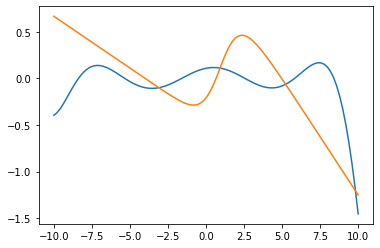

In [162]:
plt.plot(x_axis.detach(), (dae(x_axis.reshape(-1,1))-x_axis.reshape(-1,1)).detach()/np.sqrt(sigma))
plt.plot(x_axis.detach(), dlogp)

In [5]:
kernel_function = lambda x,y,h=1: torch.exp(-0.5*torch.cdist(x,y)**2/h**2)

In [14]:
N = 1000
x = torch.randn((N,2))
eps = 0.5
h = 0.5
for i in range(500):
    x = x.clone().detach()
    x.requires_grad=True
    logp = p.log_prob(x)
    #dlogp = torch.autograd.grad(logp,x, torch.ones(logp.shape),only_inputs=True)[0]
    dlogp = f(x)
    K = kernel_function(x,x, h=h)
    dK = -K@x 
    sumK = K.sum(1)
    for i in range(x.shape[1]):
        dK[:,i] = dK[:,i] + x[:,i]*sumK 
    dK /= h**2

    phi_x = 1/N*(K@dlogp + dK)
    x = x + eps*phi_x
    print(x[0])

NameError: name 'p' is not defined

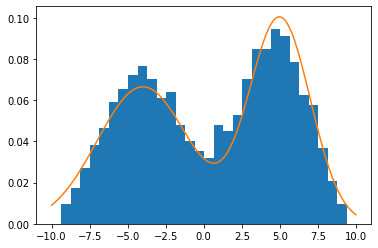

In [398]:
plt.hist(x.detach().numpy(), density=True,bins=30)
plt.plot(x_axis.detach(), p.log_prob(x_axis.reshape(-1,1)).exp().detach())

In [103]:
# Sbi
import sbi
from sbi.analysis import pairplot
# Sbi benchmark
import sbibm
from sbibm.algorithms.sbi.utils import wrap_posterior, wrap_prior_dist, wrap_simulator_fn

In [134]:
task = sbibm.get_task("gaussian_linear")
prior = task.get_prior_dist()
simulator = task.get_simulator()

thetas = prior.sample((10000,))
xs = simulator(thetas)

joint = torch.hstack([thetas,xs])
x_obs = task.get_observation(1)

In [153]:
data = torch.utils.data.DataLoader(joint, shuffle=True, batch_size=1000)
f = torch.nn.Sequential(torch.nn.Linear(20,100),torch.nn.Linear(100,100), torch.nn.Tanh(),torch.nn.Linear(100,20))

In [162]:
optimizer = torch.optim.Adam(list(f.parameters()) ,lr=1e-3)
for i in range(100):
    for samples in data:
        optimizer.zero_grad()
        #samples = samples[:,0].unsqueeze(1)
        samples = samples.clone()
        samples.requires_grad=True
        y = f(samples)
        loss = 0
        for i in range(20):
            l1 = torch.mean(y[:,i]**2)
            l2 = torch.autograd.grad(y[:,i], samples, torch.ones_like(y[:,i]), create_graph=True)[0][:,i].mean()
            loss += l1 + 2*l2 
        loss.backward()
        optimizer.step()
    print(loss)

tensor(-306.0408, grad_fn=<AddBackward0>)
tensor(-312.9712, grad_fn=<AddBackward0>)
tensor(-314.6967, grad_fn=<AddBackward0>)
tensor(-309.6398, grad_fn=<AddBackward0>)
tensor(-317.3926, grad_fn=<AddBackward0>)
tensor(-311.5958, grad_fn=<AddBackward0>)
tensor(-315.1263, grad_fn=<AddBackward0>)
tensor(-312.1922, grad_fn=<AddBackward0>)
tensor(-313.7589, grad_fn=<AddBackward0>)
tensor(-314.3896, grad_fn=<AddBackward0>)
tensor(-318.1891, grad_fn=<AddBackward0>)
tensor(-309.6212, grad_fn=<AddBackward0>)
tensor(-316.9066, grad_fn=<AddBackward0>)
tensor(-325.1443, grad_fn=<AddBackward0>)
tensor(-318.7430, grad_fn=<AddBackward0>)
tensor(-320.2216, grad_fn=<AddBackward0>)
tensor(-314.7485, grad_fn=<AddBackward0>)
tensor(-325.5694, grad_fn=<AddBackward0>)
tensor(-312.4666, grad_fn=<AddBackward0>)
tensor(-317.0607, grad_fn=<AddBackward0>)
tensor(-320.5677, grad_fn=<AddBackward0>)
tensor(-322.1442, grad_fn=<AddBackward0>)
tensor(-319.5731, grad_fn=<AddBackward0>)
tensor(-314.4603, grad_fn=<AddBack

In [163]:
N = 2000
x = torch.randn((N,10))
eps = 0.2
h = 0.5
for i in range(5000):
    x = x.clone().detach()
    x.requires_grad=True
    #logp = posterior.net.log_prob(x_obs.repeat(N,1), x) + posterior._prior.log_prob(x)
    #dlogp = torch.autograd.grad(logp,x, torch.ones(logp.shape),only_inputs=True)[0]
    joint_sample = torch.hstack([x, x_obs.repeat(N,1)])
    f.eval()
    dlogp = f(joint_sample)[:,:10]

    K = kernel_function(x,x, h=h)
    dK = -K@x 
    sumK = K.sum(1)
    for i in range(x.shape[1]):
        dK[:,i] = dK[:,i] + x[:,i]*sumK 
    dK /= h**2

    phi_x = 1/N*(K@dlogp + dK)
    x = x + eps*phi_x
    print(x[0])

tensor([ 0.4837,  1.5429, -0.3499, -1.0820, -0.6404,  0.6530,  0.7204, -1.4013,
         1.2254,  0.2607], grad_fn=<SelectBackward>)
tensor([ 0.4837,  1.5420, -0.3496, -1.0811, -0.6401,  0.6526,  0.7201, -1.4000,
         1.2241,  0.2608], grad_fn=<SelectBackward>)
tensor([ 0.4836,  1.5412, -0.3494, -1.0802, -0.6398,  0.6523,  0.7198, -1.3987,
         1.2229,  0.2608], grad_fn=<SelectBackward>)
tensor([ 0.4835,  1.5403, -0.3491, -1.0792, -0.6395,  0.6520,  0.7195, -1.3973,
         1.2217,  0.2609], grad_fn=<SelectBackward>)
tensor([ 0.4834,  1.5395, -0.3488, -1.0783, -0.6392,  0.6516,  0.7192, -1.3960,
         1.2205,  0.2609], grad_fn=<SelectBackward>)
tensor([ 0.4833,  1.5386, -0.3485, -1.0774, -0.6389,  0.6513,  0.7188, -1.3947,
         1.2192,  0.2610], grad_fn=<SelectBackward>)
tensor([ 0.4833,  1.5378, -0.3482, -1.0765, -0.6386,  0.6510,  0.7185, -1.3934,
         1.2180,  0.2610], grad_fn=<SelectBackward>)
tensor([ 0.4832,  1.5369, -0.3479, -1.0755, -0.6382,  0.6506,  0.7182

KeyboardInterrupt: 

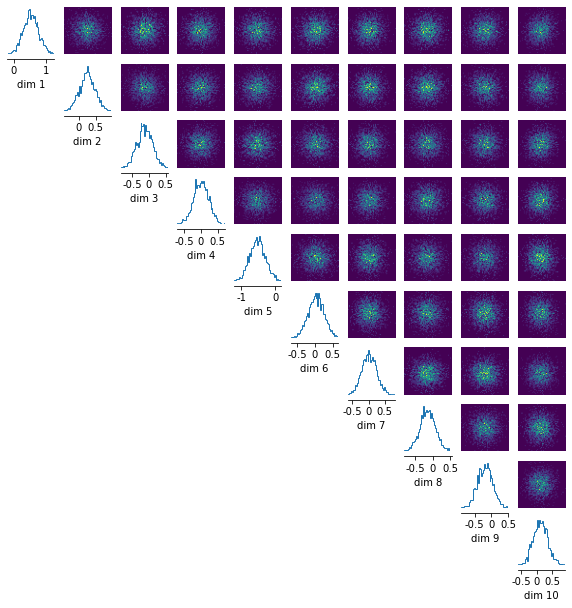

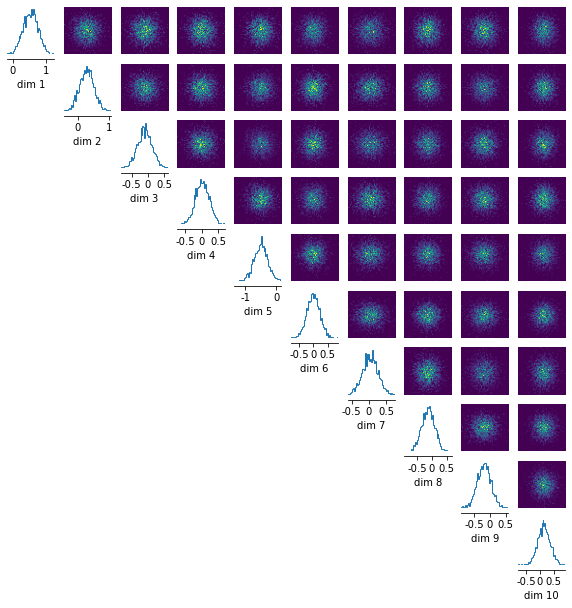

In [164]:
_ = pairplot(x.detach().numpy())
_ = pairplot(ref_samples[:2000])

In [165]:
from sbibm.metrics import c2st 
ref_samples = task.get_reference_posterior_samples(1)
c2st(x.detach(),ref_samples[:2000])

tensor([0.4647])

In [166]:
transforms = torch.distributions.transforms.ComposeTransform([torch.distributions.transforms.AffineTransform(loc=0.5*torch.ones(2), scale=0.5*torch.ones(2)), torch.distributions.SigmoidTransform().inv]) 

In [167]:
task = sbibm.get_task("two_moons")
prior = task.get_prior_dist()
simulator = task.get_simulator()

prior = wrap_prior_dist(prior, transforms)
simulator = wrap_simulator_fn(simulator,transforms)

thetas = prior.sample((10000,))
xs = simulator(thetas)

joint = torch.hstack([thetas,xs])

In [168]:
x_obs = task.get_observation(1)

In [172]:
inf = sbi.inference.SNLVI(prior)
dest = inf.append_simulations(thetas,xs).train(max_num_epochs=100)
inf.neural_net=dest

Neural network successfully converged after 95 epochs.


In [173]:
posterior = inf.build_posterior(flow="spline_autoregressive")
posterior.set_default_x(x_obs)

VariationalPosterior(
               method_family=snle,
               net=<a Flow, see `.net` for details>,
               prior=TransformedDistribution(),
               x_shape=torch.Size([1, 2]))
               

In [1]:
posterior.train(loss="forward_kl")

(<Figure size 720x720 with 4 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>]], dtype=object))

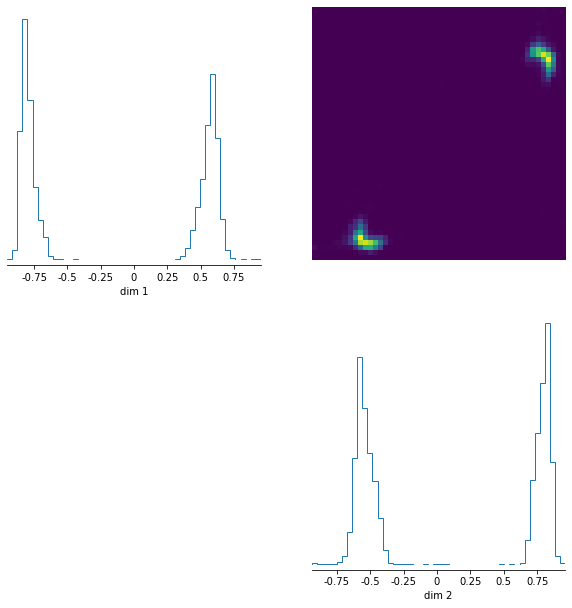

In [182]:
samples = posterior.sample((10000,))
pairplot(transforms.inv(samples))

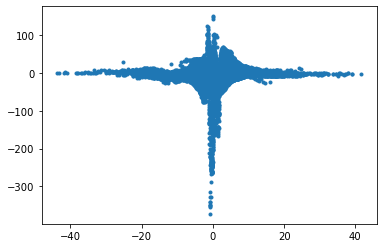

In [183]:
x = posterior._prior.sample((10000,))*5
x.requires_grad=True
logp = posterior.net.log_prob(x_obs.repeat(10000,1), x) + posterior._prior.log_prob(x)
dlogp = torch.autograd.grad(logp,x, torch.ones(logp.shape),only_inputs=True)[0]

plt.plot(x[:,0].detach(),dlogp[:,0].detach(),".")
plt.show()
plt.plot(x[:,1].detach(),dlogp[:,1].detach(),".")

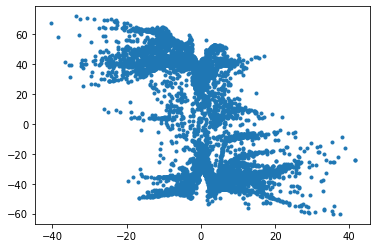

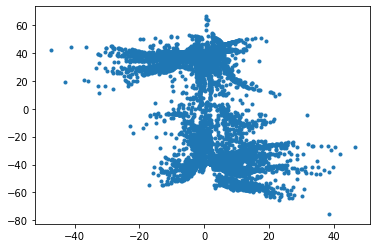

In [249]:
x = posterior._prior.sample((10000,))*5
x = torch.hstack((x, x_obs.repeat(10000,1)))
x.requires_grad=True
dlogp = f(x)

plt.plot(x[:,0].detach(),dlogp[:,0].detach(),".")
plt.show()
plt.plot(x[:,1].detach(),dlogp[:,1].detach(),".")

In [226]:
data = torch.utils.data.DataLoader(joint, shuffle=True, batch_size=5000)

In [227]:
f = torch.nn.Sequential(torch.nn.Linear(4,100),torch.nn.Linear(100,100), torch.nn.Tanh(),torch.nn.Linear(100,100), torch.nn.Tanh(),torch.nn.Linear(100,4))

In [245]:
optimizer = torch.optim.Adam(list(f.parameters()) ,lr=1e-3)
for i in range(500):
    for samples in data:
        optimizer.zero_grad()
        #samples = samples[:,0].unsqueeze(1)
        samples = samples.clone()
        samples.requires_grad=True
        y = f(samples)
        loss = 0
        for i in range(4):
            l1 = torch.mean(y[:,i]**2)
            l2 = torch.autograd.grad(y[:,i], samples, torch.ones_like(y[:,i]), create_graph=True)[0][:,i].mean()
            loss += l1 + 2*l2 
        loss.backward()
        optimizer.step()
    print(loss)

tensor(-5759.1113, grad_fn=<AddBackward0>)
tensor(-7196.8154, grad_fn=<AddBackward0>)
tensor(-7142.4170, grad_fn=<AddBackward0>)
tensor(-7643.0605, grad_fn=<AddBackward0>)
tensor(-7617.2939, grad_fn=<AddBackward0>)
tensor(-7859.1816, grad_fn=<AddBackward0>)
tensor(-7731.2686, grad_fn=<AddBackward0>)
tensor(-7811.1484, grad_fn=<AddBackward0>)
tensor(-8075.9595, grad_fn=<AddBackward0>)
tensor(-8038.3154, grad_fn=<AddBackward0>)
tensor(-7968.1934, grad_fn=<AddBackward0>)
tensor(-8006.4219, grad_fn=<AddBackward0>)
tensor(-8090.7080, grad_fn=<AddBackward0>)
tensor(-8066.6992, grad_fn=<AddBackward0>)
tensor(-8034.1484, grad_fn=<AddBackward0>)
tensor(-8154.6016, grad_fn=<AddBackward0>)
tensor(-8282.4639, grad_fn=<AddBackward0>)
tensor(-8058.7139, grad_fn=<AddBackward0>)
tensor(-8163.5327, grad_fn=<AddBackward0>)
tensor(-8072.9033, grad_fn=<AddBackward0>)
tensor(-8206.8047, grad_fn=<AddBackward0>)
tensor(-8166.8203, grad_fn=<AddBackward0>)
tensor(-8195.7539, grad_fn=<AddBackward0>)
tensor(-793

In [246]:
N = 2000
x = torch.randn((N,2))
eps = 0.5
h = 0.01
for i in range(3000):
    x = x.clone().detach()
    x.requires_grad=True
    #logp = posterior.net.log_prob(x_obs.repeat(N,1), x) + posterior._prior.log_prob(x)
    #dlogp = torch.autograd.grad(logp,x, torch.ones(logp.shape),only_inputs=True)[0]
    joint_sample = torch.hstack([x, x_obs.repeat(N,1)])
    f.eval()
    dlogp = f(joint_sample)[:,:2]

    K = kernel_function(x,x, h=h)
    dK = -K@x 
    sumK = K.sum(1)
    for i in range(x.shape[1]):
        dK[:,i] = dK[:,i] + x[:,i]*sumK 
    dK /= h**2

    phi_x = 1/N*(K@dlogp + dK)
    x = x + eps*phi_x
    print(x[0])

tensor([0.4511, 0.0185], grad_fn=<SelectBackward>)
tensor([0.4469, 0.0224], grad_fn=<SelectBackward>)
tensor([0.4427, 0.0263], grad_fn=<SelectBackward>)
tensor([0.4386, 0.0303], grad_fn=<SelectBackward>)
tensor([0.4345, 0.0343], grad_fn=<SelectBackward>)
tensor([0.4306, 0.0384], grad_fn=<SelectBackward>)
tensor([0.4266, 0.0424], grad_fn=<SelectBackward>)
tensor([0.4227, 0.0464], grad_fn=<SelectBackward>)
tensor([0.4189, 0.0505], grad_fn=<SelectBackward>)
tensor([0.4151, 0.0545], grad_fn=<SelectBackward>)
tensor([0.4113, 0.0585], grad_fn=<SelectBackward>)
tensor([0.4075, 0.0625], grad_fn=<SelectBackward>)
tensor([0.4038, 0.0664], grad_fn=<SelectBackward>)
tensor([0.4001, 0.0704], grad_fn=<SelectBackward>)
tensor([0.3964, 0.0743], grad_fn=<SelectBackward>)
tensor([0.3928, 0.0782], grad_fn=<SelectBackward>)
tensor([0.3891, 0.0821], grad_fn=<SelectBackward>)
tensor([0.3855, 0.0860], grad_fn=<SelectBackward>)
tensor([0.3820, 0.0899], grad_fn=<SelectBackward>)
tensor([0.3784, 0.0938], grad_f

(<Figure size 720x720 with 4 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>]], dtype=object))

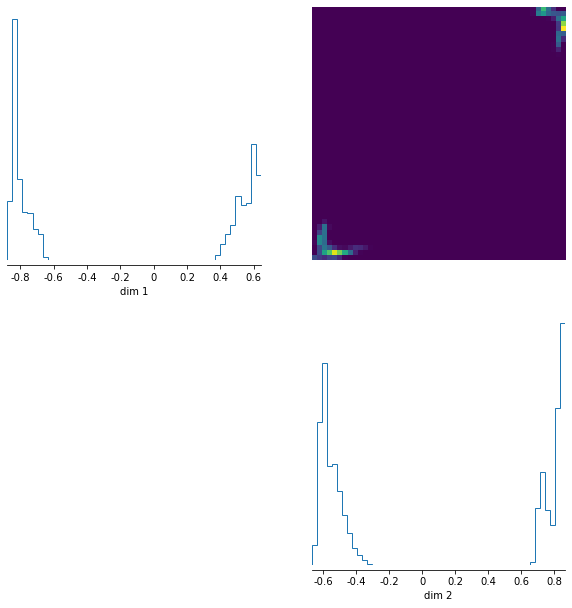

In [247]:
samples = transforms.inv(x)
pairplot(samples.detach())

In [248]:
from sbibm.metrics import c2st 
ref_samples = task.get_reference_posterior_samples(1)
c2st(samples.detach(),ref_samples[:2000])

tensor([0.5460])